# MUSES Workflow demonstrations

**Tutorial to use MUSES**

*Summer Internship in Computational Nuclear Astrophysics 2025*

**Steps**

Clone repo from gitlab https://gitlab.com/nsf-muses/module-cmf/cmf-ce-tutorial-2025.git

*You need a gitlab account for this.*

or

you can download the required files from the shared drive folder

Upload all the files from the repo to the file explorer (left side)

This is a temporary session, you will have to repeat this process every time.


- **CMF++ (1D)**
- **CMF++ (2D, baryons) $\rightarrow$ Lepton**
- **CMF++ (2D, baryons) $\rightarrow$ Lepton $\rightarrow$ QLIMR**
- **QLIMR (user uploads EoS)**
- **CMF++ (2D, baryons+quarks) $\rightarrow$ Lepton x2 $\rightarrow$ Synthesis** (homework example)
---


## **Introduction**

This notebook demonstrates how to use the [**MUSES Calculation Engine**](https://ce.musesframework.io/) to generate neutralized Equations of State (EoS) from the CMF++ module [[Phys. Rev. D 111, 094030](https://doi.org/10.1103/PhysRevD.111.094030), [arXiv:2409.06837](https://arxiv.org/abs/2409.06837)] and how to pipe these results to QLIMR.

We provide configuration and workflow files for the following scenarios:

- singleton: CMF++ 1D ($\mu_B$) bayonic EoS

- chain: CMF++ 2D ($\mu_B, \mu_Q$) baryonic EoS → Lepton

- singleton: QLIMR, where the users supply a properly formatted EoS

- Full chain: CMF++ 2D ($\mu_B, \mu_Q$) baryonic EoS → Lepton → QLIMR

A sample homework problem is also included. In this example, the Synthesis module is used to compute the quark-hadron phase transition (Maxwell or Gibbs) for the CMF model.

- Full chain + group: CMF++ 2D ($\mu_B, \mu_Q$) baryons+quarks EoS → Lepton x2 → synthesis → QLIMR

If you have any questions, feel free to reach out via our [community forum](https://forum.musesframework.io/).

Also, don’t forget to visit [our website](https://musesframework.io/) for more resources.

---

**Author**: Nikolas Cruz Camacho and Carlos Conde

**Contact**: cnc6@illinois.edu and carlosc7@illinois.edu

**Developers of CMF**: Nikolas Cruz Camacho, Mateus Pelicer, and Rajesh Kumar


## Warning!

**Before executing any cells, please upload the necessary files from [this repository](https://gitlab.com/nsf-muses/module-cmf/cmf-ce-tutorial-2025) to your Colab session.**

After cloning the repository, click on the Files tab (in the left-hand panel), then click on Upload to session storage. Then run cell by cell or click on Runtime, run all.

#### Install plotly for interactive plots



In [17]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import packages

In [18]:
import os
import numpy as np
import pandas as pd
import sys
import yaml
import logging
import time
import getpass
import matplotlib.pyplot as plt

from collections import defaultdict
from matplotlib.lines import Line2D

from calculation_engine_api import CalculationEngineApi
from utils import monitor_job, download_successful_job
from plot_utils import plot_1D_CMF_EoS, plot_2D_CMF_EoS, plot_2D_CMF_EoS_with_Lepton, plot_QLIMR_observables

#### Setup environment

#### **Replace getpass.getpass() by your API token or copy when requested and hit enter**

In [19]:
os.environ['LOG_LEVEL'] = str(logging.INFO)
os.environ['CE_API_URL_PROTOCOL'] = 'https'
os.environ['CE_API_URL_AUTHORITY'] = 'ce.musesframework.io'
os.environ['CE_API_TOKEN'] = '76792fdaee741b3fa4d20ab3599ce8f1029b31c1'

#### Obtain an API object to interact with the Calculation Engine

In [20]:
api = CalculationEngineApi()

#### Setup directories

In [21]:
base_output_dir=os.path.join(os.getcwd(), 'downloads/')
base_plot_dir=os.path.join(os.getcwd(), 'plots/')

if not os.path.exists(base_output_dir):
    os.makedirs(base_output_dir)

if not os.path.exists(base_plot_dir):
    os.makedirs(base_plot_dir)

## Define options for the modules

Set up the options for the CMF, Lepton and QLIMR modules

In [22]:
## CMF options
# vector_potential: 1, 2, 3, 4
# use_hyperons: True, False
# use_decuplet: True, False
## type: Baryons, Maxwell [Maxwell and Gibbs will automatically include quarks]

cmf_options = [
    {'vector_potential': 4,
    'label': 'CMF++ C4 OD',
    'use_hyperons': True,
    'use_decuplet': True,
    'type': 'cmf_baryons_qlimr'
    },
]


#Lepton options
use_muons= False
calculate_derivatives= True

# QLIMR options
Ec_min = 150. # minimum central energy density in MeV/fm^3
M_res= 0.05 # resolution in solar masses
R_res= 0.05  # resolution in km

## Define workflow functions

In [23]:
def cmf_baryons_lepton_qlimr_wf_config(vector_potential=4, use_hyperons=True, use_decuplet=True, calculate_derivatives=False, use_muons=False, Ec_min=100, M_res=0.01, R_res=0.01):
    return yaml.safe_load(f'''
processes:
- name: cmf
  module: cmf_solver
  config:
    computational_parameters:
      options:
        vector_potential: {vector_potential}
        use_octet: true
        use_hyperons: {use_hyperons}
        use_decuplet: {use_decuplet}
        use_quarks: false
      output_files:
        output_Lepton: true
        output_debug: false
        output_flavor_equilibration: false
        output_format: CSV
        output_particle_properties: false
      production_run: true
      variables:
          muB_begin: 940.0
          muB_end: 1600.0
          muB_step: 20.0
          muQ_begin: -400.0
          muQ_end: 0.0
          muQ_step: 5.0
- name: lepton-cmf
  module: lepton
  config:
    global:
      run_name: ''
      use_beta_equilibrium: true
      use_charge_neutrality: false
    output:
      output_derivatives: {calculate_derivatives}
      output_particle_properties: false
    particles:
      use_electron: true
      use_muon: {use_muons}
  pipes:
    input_eos:
      label: CMF_for_Lepton_baryons_only
      module: cmf_solver
      process: cmf
- name: qlimr-cmf
  module: qlimr
  pipes:
    eos:
      label: eos_beta_equilibrium
      module: lepton
      process: lepton-cmf
  config:
    inputs:
      eos_name: eos
      initial_epsilon: {Ec_min}
      resolution_in_NS_M: {M_res}
      resolution_in_NS_R: {R_res}
    options:
      eps_sequence: true
      output_format: csv
      stable_branch: true
    outputs:
      compute_inertia: true
      compute_love: true
      compute_mass_and_radius_correction: false
      compute_quadrupole: true
      local_functions: false
components:
- type: chain
  name: cmf_baryons_qlimr
  sequence:
    - cmf
    - lepton-cmf
    - qlimr-cmf
''')





## Launch the jobs

In [24]:
jobs=[]

for cmf_option in cmf_options:

        if cmf_option['type'] == 'cmf_baryons_qlimr':
            wf_config = cmf_baryons_lepton_qlimr_wf_config(cmf_option['vector_potential'], cmf_option['use_hyperons'],  cmf_option['use_decuplet'], calculate_derivatives, use_muons)
            name = f"CMF C{cmf_option['vector_potential']} + Lepton + QLIMR tutorial 2025"
        else:
            raise ValueError('Invalid CMF type')

        job_response = api.job_create(
            name=name,
            description=name,
            config={
            "workflow": {
                "config": wf_config
            }
        })

        jobs.append({
            'model': 'CMF',
            'uuid': job_response['uuid'],
            **cmf_option
        })




#### Monitor the jobs until they are finished saves the result (Success, failure, etc.)

In [25]:
import concurrent.futures
max_jobs_monitored= 6
submission_delay= 30

with concurrent.futures.ThreadPoolExecutor(max_workers=max_jobs_monitored) as executor:

    status_jobs = {}

    for job in jobs:

        try:
            job_id = job['uuid']

            future = executor.submit(monitor_job, job_id, api, sleep_interval=submission_delay)

            status_jobs[future] = job

        except Exception as e:
            print(f"Error retrieving job submission result for {job['label']}  {e}")


    for future in concurrent.futures.as_completed(status_jobs):
        job = status_jobs[future]
        try:


            status= future.result()

            job['result'] = status
        except Exception as e:

            print(f"Error retrieving job status for{job['label']}: {e}")
            job['status'] = 'ERROR'


#### how to download data from the CE to local?

In [26]:
for job in jobs:
  job_response = api.job_list(job['uuid'])
  download_successful_job(job['uuid'], job_response, api)

  "/cmf/log.json"...
  "/cmf/opt/output/CMF_output_for_Lepton_baryons.csv"...
  "/cmf/opt/output/CMF_output_for_Lepton_quarks.csv"...
  "/cmf/opt/output/CMF_output_metastable.csv"...
  "/cmf/opt/output/CMF_output_stable.csv"...
  "/cmf/opt/output/CMF_output_unstable.csv"...
  "/cmf/opt/output/config.yaml"...
  "/cmf/opt/output/status.yaml"...
  "/cmf/opt/output/validated_config.yaml"...
  "/meta.yaml"...
  "/workflow.yaml"...
  "/lepton-cmf/log.json"...
  "/lepton-cmf/opt/output/beta_equilibrium_derivatives.csv"...
  "/lepton-cmf/opt/output/beta_equilibrium_eos.csv"...
  "/lepton-cmf/opt/output/config.yaml"...
  "/lepton-cmf/opt/output/info.yaml"...
  "/lepton-cmf/opt/output/status.yaml"...
  "/qlimr-cmf/log.json"...
  "/qlimr-cmf/opt/output/observables.csv"...
  "/qlimr-cmf/opt/output/status.yaml"...


## Plot the results from the jobs

### Define the data columns

In [27]:
cmf_cols = ['T', 'muB', 'muS', 'muQ', 'nB', 'nS', 'nQ',  'E', 'P', 's', 'sigma_MF', 'zeta_MF', 'delta_MF', 'omega_MF', 'phi_MF', 'rho_MF', 'phi_order_F', 'nB_noPol', 'Quark_nB', 'Octet_nB', 'Decuplet_nB']
cmf_for_lepton_cols = ['T', 'muB', 'muS', 'muQ', 'nB', 'nS', 'nQ', 'E', 'P', 's', 'nB_noPol']
MUSES_eos_cols = ['T', 'muB', 'muS', 'muQ', 'nB', 'nS', 'nQ', 'E', 'P', 's']
derivative_cols = ['T', 'muB', 'muS', 'muQ', 'nB', 'nS', 'nQ', 'cs2', 'chi1', 'chi2', 'chi3']
transition_cols = ['T', 'muB', 'muS', 'muQ', 'nB', 'nS', 'nQ', 'E', 'P', 's', 'transition']
qlimr_cols = ['e_c', 'R', 'M', 'I', 'L', 'Q', 'e_s', 'R_eq_corr', 'R_corr', 'M_corr']
na_values = ['NA', 'NAN', 'NaN', 'nan', '-NAN']

 ### Read data files

In [28]:
for job in jobs:
    if job['result']['status'] == 'SUCCESS':
        if job['model'] == 'CMF':

            job['cmf_eos'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'cmf', 'opt', 'output', 'CMF_output_stable.csv'),
                names=cmf_cols, na_values=na_values, sep=',')

            time.sleep(0.8)

            if job['type'] == 'cmf_only':

                job['transition'] = pd.DataFrame()
                job['derivatives'] = pd.DataFrame()
                job['observables'] = pd.DataFrame()

            elif job['type'] == 'cmf_baryons':
                job['eos'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'lepton-cmf', 'opt', 'output', 'beta_equilibrium_eos.csv'),
                    names=MUSES_eos_cols, na_values=na_values, sep=',')

                job['transition'] = pd.DataFrame()

                time.sleep(0.8)
                job['derivatives'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'lepton-cmf', 'opt', 'output', 'beta_equilibrium_derivatives.csv'),
                    names=derivative_cols, na_values=na_values, sep=',')

                job['observables'] = pd.DataFrame()

            elif job['type'] == 'cmf_baryons_qlimr':
                job['eos'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'lepton-cmf', 'opt', 'output', 'beta_equilibrium_eos.csv'),
                    names=MUSES_eos_cols, na_values=na_values, sep=',')

                time.sleep(0.8)
                job['transition'] = pd.DataFrame()

                job['derivatives'] = pd.DataFrame()

                job['observables'] = job['observables'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'qlimr-cmf', 'opt', 'output', 'observables.csv'),
                    names=qlimr_cols, na_values=na_values, sep=',')

            elif job['type'] == 'cmf_maxwell':
                job['eos'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'synthesis', 'opt', 'output', 'eos.csv'),
                    names=MUSES_eos_cols, na_values=na_values, sep=',')

                time.sleep(0.8)
                job['transition'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'synthesis', 'opt', 'output', 'transition.csv'),
                    names=transition_cols, na_values=na_values, sep=',')

                time.sleep(0.8)
                job['derivatives'] = pd.read_csv(
                
                os.path.join('./downloads',job['uuid'],'synthesis', 'opt', 'output', 'eos_derivatives.csv'),
                    names=derivative_cols, na_values=na_values, sep=',')

                job['observables'] = pd.DataFrame()

        elif job['model'] == 'QLIMR':
                job['eos'] = pd.DataFrame()
                job['transition'] = pd.DataFrame()
                job['derivatives'] = pd.DataFrame()
                job['observables'] = api.read_job_file_to_dataframe(
                    job['uuid'],
                    os.path.join('qlimr-singleton', 'opt', 'output', 'observables.csv'),
                    names=qlimr_cols, na_values=na_values, sep=',')

#### Print dataframe read

In [29]:
jobs[0]['cmf_eos'].head()

,T,muB,muS,muQ,nB,nS,nQ,E,P,s,...,zeta_MF,delta_MF,omega_MF,phi_MF,rho_MF,phi_order_F,nB_noPol,Quark_nB,Octet_nB,Decuplet_nB
0,0.0,940.0,0.0,-400.0,0.151628,-0.151628,-0.151628,192.593234,10.588698,0.0,...,-94.910395,-8.891580,14.886417,-6.411649,-15.957108,0.0,0.151628,0.0,0.151628,0.0
1,0.0,1000.0,0.0,-400.0,0.215339,-0.228291,-0.215339,280.013884,21.460558,0.0,...,-90.586181,-12.089803,20.281360,-9.731295,-21.980390,0.0,0.215339,0.0,0.215339,0.0
2,0.0,1020.0,0.0,-400.0,0.243797,-0.275144,-0.243272,319.932557,26.049359,0.0,...,-88.408196,-13.215019,22.142002,-11.703693,-23.952514,0.0,0.243797,0.0,0.243797,0.0
3,0.0,1040.0,0.0,-400.0,0.274197,-0.319809,-0.267367,360.883792,31.228442,0.0,...,-86.292312,-14.128460,24.337479,-13.612665,-25.742945,0.0,0.274197,0.0,0.274197,0.0
4,0.0,1060.0,0.0,-400.0,0.304218,-0.362345,-0.289079,401.089034,37.014180,0.0,...,-84.313447,-14.881026,26.552775,-15.445588,-27.376376,0.0,0.304218,0.0,0.304218,0.0


### $\, 1D \, EOS$

#### $P(\varepsilon)$

In [30]:
plot_1D_CMF_EoS(jobs[0]['cmf_eos'], 'E', 'P')

Plotting 1D CMF EOS for columns: E vs P


#### $P(n_B)$

In [31]:
plot_1D_CMF_EoS(jobs[0]['cmf_eos'], 'nB', 'P')

Plotting 1D CMF EOS for columns: nB vs P


### $2D \, EOS $


#### $P(\varepsilon) \, vs \, \mu_Q$

In [32]:
plot_2D_CMF_EoS(jobs[0]['cmf_eos'], 'E', 'muQ', 'P')

Plotting 2D CMF EOS for columns: E vs muQ vs P


#### $P(\varepsilon) \, vs \, n_Q$

In [33]:
plot_2D_CMF_EoS(jobs[0]['cmf_eos'], 'E', 'nQ', 'P')

Plotting 2D CMF EOS for columns: E vs nQ vs P


### $2D \, EOS \rightarrow \, Lepton$

#### $P(\varepsilon) \, vs \, \mu_Q$

In [34]:
plot_2D_CMF_EoS_with_Lepton(jobs[0]['cmf_eos'], jobs[0]['eos'], "muQ")

Plotting 2D CMF EOS with Lepton data


#### $P(\varepsilon) \, vs \, n_Q$

In [35]:
plot_2D_CMF_EoS_with_Lepton(jobs[0]['cmf_eos'], jobs[0]['eos'], "nQ")

Plotting 2D CMF EOS with Lepton data


### $2D \, EOS \rightarrow \, Lepton → QLIMR$

In [36]:
plot_QLIMR_observables(jobs[0]['observables'], 'R', 'M')

Plotting 1D QLIMR observables for columns: R vs M


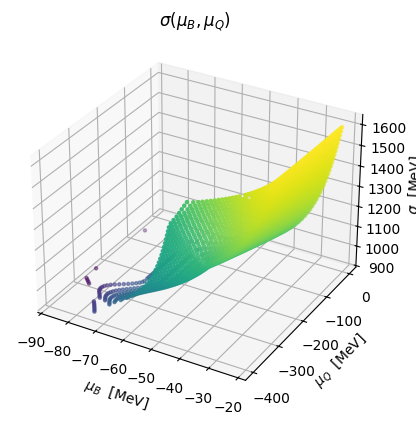

In [37]:
ax  = plt.figure().add_subplot(111, projection="3d")

ax.scatter(jobs[0]['cmf_eos']['sigma_MF'],jobs[0]['cmf_eos']["muQ"],jobs[0]['cmf_eos']["muB"],c=jobs[0]['cmf_eos']['sigma_MF'],cmap='viridis', s=5)

ax.set_xlabel(r'$\mu_B$  [MeV]')
ax.set_ylabel(r'$\mu_Q$  [MeV]')
ax.set_zlabel(r'$\sigma$  [MeV]')
ax.set_title(r'$\sigma(\mu_B,\mu_Q)$')

plt.show()

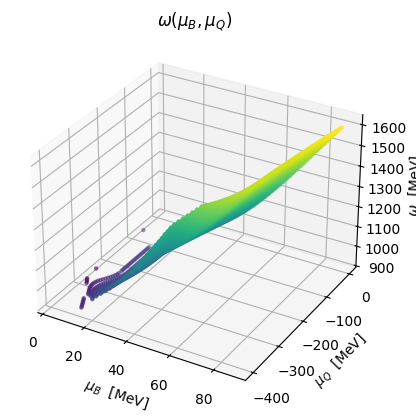

In [38]:
ax  = plt.figure().add_subplot(111, projection="3d")

ax.scatter(jobs[0]['cmf_eos']['omega_MF'],jobs[0]['cmf_eos']["muQ"],jobs[0]['cmf_eos']["muB"],c=jobs[0]['cmf_eos']['omega_MF'] ,cmap='viridis', s=5)

ax.set_xlabel(r'$\mu_B$  [MeV]')
ax.set_ylabel(r'$\mu_Q$  [MeV]')
ax.set_zlabel(r'$\omega$  [MeV]')
ax.set_title(r'$\omega(\mu_B,\mu_Q)$')

plt.show()